<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/examples/tsextract_example_notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Source - https://www.kaggle.com/hsankesara/portland-oregon-avg-rider-monthly-data


### Monthly count of riders for the Portland public transportation system. The website states that it is from January 1960 through June 1969






# Importing Libraries




In [26]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

from sklearn.model_selection import train_test_split

# Load Time Series Data

In [27]:
## Load data & Filter out other columns
df = pd.read_csv("portland-oregon-average-monthly-.csv", names=["month", "ridership"], header=0)
df = df.iloc[:-1, :]

# Set time as index
df["month"] = pd.to_datetime(df["month"], format="%Y-%m")
df = df.set_index("month")
df['ridership'] = df['ridership'].astype(int)

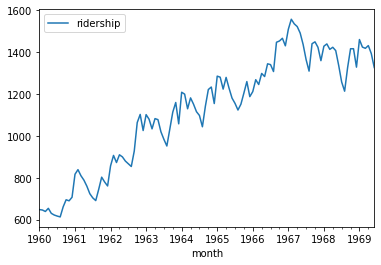

In [28]:
df.plot()

# Time Series Decomposition

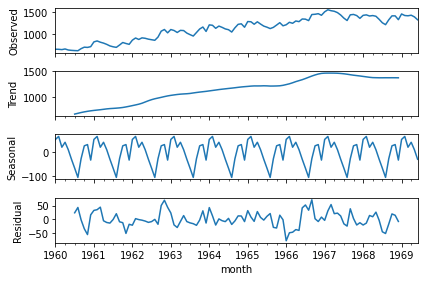

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

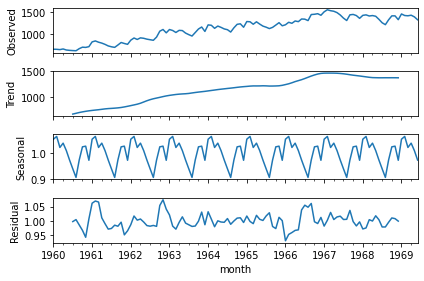

In [29]:
result = seasonal_decompose(df, model='multiplicative')
result.plot()
pyplot.show()

# De - Trend

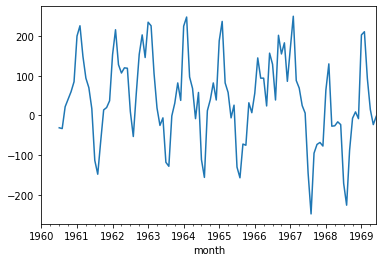

In [47]:
df["ridership"].diff(6).plot()

We notice a differencing value of 6 does a relatively good job of de-trending the data

In [30]:
! pip install tsextract

# Extracting Features

In [31]:
from tsextract.feature_extraction.extract import build_features
from tsextract.domain.statistics import median, mean

In [48]:
feature_request = {
    "window":[12], 
    "difference_statistic":[12, 6, mean], 
    "momentum_statistic":[12, 1, mean]
}

In [50]:
data = build_features(df["ridership"], feature_request, include_tzero=False, target_lag=5)

In [51]:
data.head()

,T-12,T-11,T-10,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,difference_statistic_12_6_mean,momentum_statistic_12_1_mean,Target_Tplus5
Date,,,,,,,,,,,,,,,
1961-01-01,648.0,646.0,639.0,654.0,630.0,622.0,617.0,613.0,661.0,695.0,690.0,707.0,62.500000,10.181818,724.0
1961-02-01,646.0,639.0,654.0,630.0,622.0,617.0,613.0,661.0,695.0,690.0,707.0,817.0,105.666667,2.636364,704.0
1961-03-01,639.0,654.0,630.0,622.0,617.0,613.0,661.0,695.0,690.0,707.0,817.0,839.0,126.833333,-4.000000,691.0
1961-04-01,654.0,630.0,622.0,617.0,613.0,661.0,695.0,690.0,707.0,817.0,839.0,810.0,135.666667,0.272727,745.0
1961-05-01,630.0,622.0,617.0,613.0,661.0,695.0,690.0,707.0,817.0,839.0,810.0,789.0,137.333333,-1.909091,803.0


# Feature Scaling

In [52]:
scaler_features = StandardScaler().fit(data[data.columns.values[:-1]])
scaled_features = scaler_features.transform(data[data.columns.values[:-1]])

scaler_label = StandardScaler().fit(np.array(data[data.columns.values[-1]]).reshape(-1, 1))
scaled_label = scaler_label.transform(np.array(data[data.columns.values[-1]]).reshape(-1, 1))

# Data Split

In [53]:
### Split data using train proportion of 0.8
train_size = int(scaled_features[:, :-1].shape[0] * 0.8)


X_train, y_train = scaled_features[:train_size, :], scaled_label[:train_size, -1]
X_test, y_test = scaled_features[train_size:, :], scaled_label[train_size:, -1]

# Modeling

In [54]:
clf = LinearSVR(random_state=0)
clf.fit(X_train, y_train.reshape(-1, ))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=0, tol=0.0001, verbose=0)

In [55]:
train_score, test_score = clf.score(X_train, y_train), clf.score(X_test, y_test)

In [56]:
print(f"Train Score is {train_score} \n & Test Score is {test_score}")

Train Score is 0.8600266645721434 
 & Test Score is -1.6211850115631026


In [57]:
from tsextract.plots.eval import *

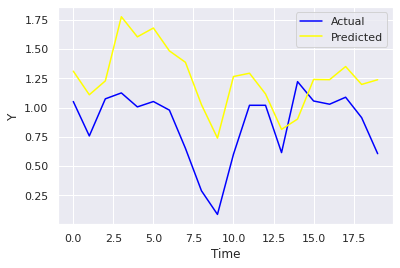

In [58]:
actualPred(y_test.reshape(-1,), clf.predict(X_test))

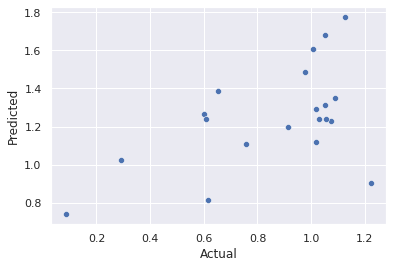

In [59]:
scatter(y_test.reshape(-1,), clf.predict(X_test))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


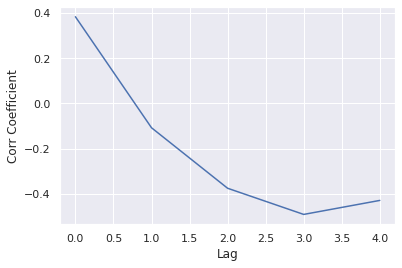

In [61]:
get_lag_corr(y_test, clf.predict(X_test), 5)

In [62]:
scaler_label.inverse_transform(clf.predict(X_test).reshape(-1, 1))

array([[1480.469728  ],
       [1436.58821079],
       [1462.36984598],
       [1581.71616289],
       [1544.33671997],
       [1560.76377557],
       [1518.17651109],
       [1496.97336274],
       [1418.26870347],
       [1355.9563046 ],
       [1470.54634042],
       [1476.6240987 ],
       [1438.13334705],
       [1372.20878529],
       [1391.4057414 ],
       [1465.03403387],
       [1464.6547099 ],
       [1489.07562035],
       [1455.81496123],
       [1464.54001162]])